# VTC_DataAnalytics

I will tackle real-life questions pertaining to VTC Data Analytics in my preferred format.

When something is unclear, I will state clearly my assumptions and will go ahead as I see fit, inlcuding all elements.

I will have fun in the process - see what I can come up with.

https://towardsdatascience.com/bayesian-ab-testing-with-pyro-cd4daff686e1

In [159]:
%%capture
# install libraries
!pip install matplotlib numpy openpyxl pandas

In [160]:
# import libraries
import sqlite3
#
import pandas as pd
import matplotlib.pyplot as plt

# Part 1

Create a database importing data from Excel.

We do this to simulate how to write an executable SQL query to answer the question.

We can do this with SQLite, which is a self-contained, serverless, zero-configuration, transactional SQL database engine.

In [161]:
conn = sqlite3.connect('VTC_DataAnalytics.db') #SQLite database file
df = pd.read_excel('mobile_events.xlsx') #path to the Excel file dataset
df.to_sql('MOBILE_EVENTS', conn, if_exists='replace', index=False) #a table within the database


65534

Define a single SQL query, assuming read-only access to the database (i.e. do not use ``CREATE TABLE``)

What is the percentage of sessions which end up in a ride order everyday?

Assumptions:
1) Session definition: a Session is a product life-cycle journey by ``device_id`` that starts with "pickup_shown" and finishes with "ride_order_tapped".\
Note: a Sesion in Google Analytics within the context of mobile apps is a journey since the user opens the App and closes it. This has to not be confused with a Session within our VTC context.

2) We will be agnostic as to what happens within the session, and only measure sessions with a "pickup_shown" start and a "ride_order_tapped" end. The user can go back and forth during the pre-order session, so we only count the first "pickup_shown".

3) We need to accommodate for the possibility of the same ``device_id`` having multiple sessions during the day.

4) We need to accommodate for the possibility of a session to start before the end of day threshold, in which case we will use the start of the session ("pickup_shown") as the timestamp that defines the daily session that can potentially end up in a ride order.

In [162]:
query = """
WITH first_pickup_shown AS (
  SELECT
    device_id,
    event_name,
    MIN(timestamp) as datetime
  FROM MOBILE_EVENTS
  WHERE event_name = 'pickup_shown'
  GROUP BY device_id, DATE(timestamp)
),

first_pickup_after_ride AS (
  WITH ride_order_tapped_events AS (
    SELECT
      device_id,
      timestamp as ride_order_tapped_time
    FROM MOBILE_EVENTS
    WHERE event_name = 'ride_order_tapped'
  )

  SELECT
    R.device_id,
    event_name,
    MIN(M.timestamp) as datetime
  FROM ride_order_tapped_events R
  JOIN MOBILE_EVENTS M
    ON R.device_id = M.device_id
    AND (M.event_name = 'pickup_shown' OR M.event_name = 'ride_order_tapped')
    AND M.timestamp > R.ride_order_tapped_time
  GROUP BY R.device_id, R.ride_order_tapped_time
),

ride_order_tapped_events AS (
  SELECT
    device_id,
    event_name,
    timestamp as datetime
  FROM MOBILE_EVENTS
  WHERE event_name = 'ride_order_tapped'
),

combined_events AS (
  SELECT device_id, event_name, datetime FROM first_pickup_shown
  UNION ALL
  SELECT device_id, event_name, datetime FROM first_pickup_after_ride
  UNION ALL
  SELECT device_id, event_name, datetime FROM ride_order_tapped_events
),

filtered_events AS (
  SELECT
    device_id,
    event_name,
    datetime,
    LAG(event_name) OVER (PARTITION BY device_id ORDER BY datetime) as prev_event
  FROM combined_events
),

adjusted_dates AS (
  SELECT DISTINCT
    device_id, 
    event_name, 
    datetime, 
    DATE(datetime) as date,
    CASE 
      WHEN event_name = 'ride_order_tapped' 
           AND prev_event IS NULL 
        THEN DATE(DATE(datetime), '-1 day')
      ELSE DATE(datetime)
    END as adjusted_date
  FROM filtered_events
  WHERE event_name <> 'ride_order_tapped' OR prev_event <> 'ride_order_tapped'
)

SELECT
  adjusted_date,
  SUM(CASE WHEN event_name = 'pickup_shown' THEN 1 ELSE 0 END) as pickup_shown_sum,
  SUM(CASE WHEN event_name = 'ride_order_tapped' THEN 1 ELSE 0 END) as ride_order_tapped_sum,
  CASE 
    WHEN SUM(CASE WHEN event_name = 'pickup_shown' THEN 1 ELSE 0 END) <> 0 
      THEN CAST(SUM(CASE WHEN event_name = 'ride_order_tapped' THEN 1 ELSE 0 END) as float) / 
           SUM(CASE WHEN event_name = 'pickup_shown' THEN 1 ELSE 0 END)
    ELSE NULL
  END as percentage
FROM adjusted_dates
GROUP BY adjusted_date
ORDER BY adjusted_date;
"""

# Execute the query
query_results = pd.read_sql_query(query, conn)#.to_csv('test.csv')

In [163]:
query_results['percentage'] *= 100
query_results

,adjusted_date,pickup_shown_sum,ride_order_tapped_sum,percentage
0,2020-10-01,570,408,71.578947
1,2020-10-02,659,444,67.374810
2,2020-10-03,692,485,70.086705
3,2020-10-04,593,399,67.284992
4,2020-10-05,562,384,68.327402
5,2020-10-06,581,401,69.018933
6,2020-10-07,537,371,69.087523


In [164]:
print(f"Average percentage (%) of sessions that end up in a ride order on a given day: ",round(query_results['percentage'].mean(),2))

Average percentage (%) of sessions that end up in a ride order on a given day:  68.97


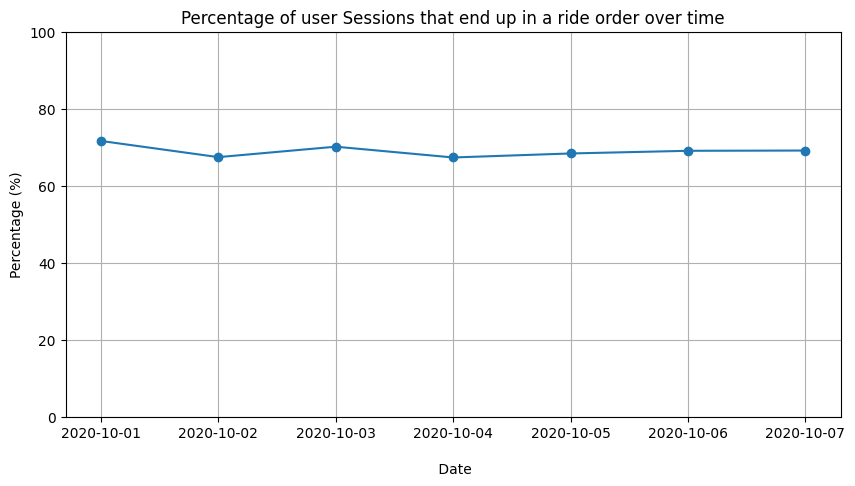

In [165]:
# Convert adjusted_date to datetime for proper plotting
query_results['adjusted_date'] = pd.to_datetime(query_results['adjusted_date'])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(query_results['adjusted_date'], query_results['percentage'], marker='o')
plt.xlabel('\n Date')
plt.ylabel('Percentage (%)')
plt.title('Percentage of user Sessions that end up in a ride order over time')
plt.ylim(0,100)
plt.grid(True)
plt.show()

We can see that the percentage of sessions that end up in a ride order is fairly stable over this time period. The average percentage (%) of sessions that end up in a ride order on a given day is of  68.97%. With the maximum (minimum) daily percentages reaching 71.58% (67.37%).

We suspect the ``payments_selected`` event to not be triggered properly by the app.
How many of them didn't fire ?

Assumptions:
1) Between "payments_shown" and "ride_order_tapped", there should be an event triggering, i.e. "payments_selected".

2) We will count the transitions from "payments_shown" to "ride_order_tapped" as a non-triggered event. We assume that this transition should have genuinely triggered the "payments_selected" event.

In [166]:
query = """
WITH ride_order_events AS (
  SELECT
      device_id,
      event_name,
      timestamp,
      LAG(event_name) OVER (PARTITION BY device_id ORDER BY timestamp) as prev_event
    FROM MOBILE_EVENTS
)

SELECT
  SUM(CASE WHEN prev_event = 'payments_shown' THEN 1 ELSE 0 END) as payments_shown_sum,
  SUM(CASE WHEN prev_event = 'payments_selected' THEN 1 ELSE 0 END) as payments_selected_sum,
  CASE 
    WHEN SUM(CASE WHEN prev_event = 'ride_order_tapped' THEN 1 ELSE 0 END) <> 0 
      THEN CAST(SUM(CASE WHEN prev_event = 'payments_selected' THEN 1 ELSE 0 END) as float) / 
           SUM(CASE WHEN event_name = 'ride_order_tapped' THEN 1 ELSE 0 END)
    ELSE NULL
  END as percentage_selected
FROM ride_order_events
WHERE event_name = 'ride_order_tapped';
"""

# Execute the query
query_results = pd.read_sql_query(query, conn)#.to_csv('test.csv')

In [167]:
query_results['percentage_selected'] *= 100
query_results['percentage_shown'] = 100 - query_results['percentage_selected']
query_results

,payments_shown_sum,payments_selected_sum,percentage_selected,percentage_shown
0,1876,619,16.880284,83.119716


In [168]:
print(f"Total number of non-triggered payment_selected events: ",query_results['payments_shown_sum'].iloc[0])
print(f"Percentage (%) of non-triggered payment_selected events over ride_order_tapped: ",round(query_results['percentage_shown'].mean(),2))

Total number of non-triggered payment_selected events:  1876
Percentage (%) of non-triggered payment_selected events over ride_order_tapped:  83.12


We can see that the total number of non-triggered ``payment_selected`` events is of 1876 events.\
To put it into perspective, the percentage (%) of non-triggered ``payment_selected`` events over the number of ``ride_order_tapped`` events is of 83.12%. This is a large percentage, indicative that there is an issue surrounding the ``payment_selected`` event within the app, as suspected.

Based on the dataset in Part 1, how would you help your Product Manager figure
out what works and what doesn’t work during the Preorder?

How would you communicate your conclusions in a concise way?

We will use data visualization to illustrate our approach.

# Part 2

Based on the dataset in Part 1, how would you help your Product Manager figure out what works and what doesn’t work during the Preorder?

I would create a Funnel Analysis which illustrates the journey that users make during the Preorder.

A Funnel Analysis will reproduce the sequence of events that users take before placing an order ``ride_order_tapped``.

With a Funnel Analysis we can check if there are certain steps in the user journey that impede a smooth exit to ``ride_order_tapped``. With this, we can potentially identify steps in the Preorder that don't work, where either the app events don't trigger or users find it difficult to go though.

In [169]:
steps = []
conversion_rates = []

In [170]:
query = """
WITH pickup_events AS (
  SELECT
      device_id,
      event_name,
      timestamp,
      LEAD(event_name) OVER (PARTITION BY device_id ORDER BY timestamp) as post_event
    FROM MOBILE_EVENTS
    WHERE event_name = 'pickup_confirmed' or event_name = 'dropoff_confirmed'
)

SELECT
  SUM(CASE WHEN post_event = 'dropoff_confirmed' THEN 1 ELSE 0 END) as dropoff_confirmed_sum,
  SUM(CASE WHEN event_name = 'pickup_confirmed' THEN 1 ELSE 0 END) as pickup_confirmed_sum,
  CASE 
    WHEN SUM(CASE WHEN event_name = 'pickup_confirmed' THEN 1 ELSE 0 END) <> 0 
      THEN CAST(SUM(CASE WHEN post_event = 'dropoff_confirmed' THEN 1 ELSE 0 END) as float) / 
           SUM(CASE WHEN event_name = 'pickup_confirmed' THEN 1 ELSE 0 END)
    ELSE NULL
  END as percentage_selected
FROM pickup_events
WHERE event_name = 'pickup_confirmed';
"""
# Execute the query
query_results = pd.read_sql_query(query, conn)#.to_csv('test.csv')
query_results['percentage_selected'] *= 100
query_results

,dropoff_confirmed_sum,pickup_confirmed_sum,percentage_selected
0,4358,4948,88.07599


In [171]:
print(f"Conversion rates (%) of pickup_confirmed to dropoff_confirmed: ",round(query_results['percentage_selected'].mean(),2))

Conversion rates (%) of pickup_confirmed to dropoff_confirmed:  88.08


In [172]:
steps.append('Pickup - Dropoff')
conversion_rates.append(round(query_results['percentage_selected'].mean(),2))

In [173]:
query = """
WITH payments_shown_events AS (
  SELECT
      device_id,
      event_name,
      timestamp,
      LEAD(event_name) OVER (PARTITION BY device_id ORDER BY timestamp) as post_event
    FROM MOBILE_EVENTS
    WHERE event_name = 'payments_shown' or event_name = 'dropoff_confirmed'
)

SELECT
  SUM(CASE WHEN post_event = 'payments_shown' THEN 1 ELSE 0 END) as payments_shown_sum,
  SUM(CASE WHEN event_name = 'dropoff_confirmed' THEN 1 ELSE 0 END) as dropoff_confirmed_sum,
  CASE 
    WHEN SUM(CASE WHEN event_name = 'dropoff_confirmed' THEN 1 ELSE 0 END) <> 0 
      THEN CAST(SUM(CASE WHEN post_event = 'payments_shown' THEN 1 ELSE 0 END) as float) / 
           SUM(CASE WHEN event_name = 'dropoff_confirmed' THEN 1 ELSE 0 END)
    ELSE NULL
  END as percentage_selected
FROM payments_shown_events
WHERE event_name = 'dropoff_confirmed';
"""
# Execute the query
query_results = pd.read_sql_query(query, conn)#.to_csv('test.csv')
query_results['percentage_selected'] *= 100
query_results

,payments_shown_sum,dropoff_confirmed_sum,percentage_selected
0,4311,5442,79.2172


In [174]:
print(f"Conversion rates (%) of dropoff_confirmed to payments_shown: ",round(query_results['percentage_selected'].mean(),2))

Conversion rates (%) of dropoff_confirmed to payments_shown:  79.22


In [175]:
steps.append('Dropoff - PaymentsShown')
conversion_rates.append(round(query_results['percentage_selected'].mean(),2))

In [176]:
query = """
WITH ride_order_tapped_events AS (
  SELECT
      device_id,
      event_name,
      timestamp,
      LEAD(event_name) OVER (PARTITION BY device_id ORDER BY timestamp) as post_event
    FROM MOBILE_EVENTS
    WHERE event_name = 'payments_shown' or event_name = 'ride_order_tapped'
)

SELECT
  SUM(CASE WHEN post_event = 'ride_order_tapped' THEN 1 ELSE 0 END) as ride_order_tapped_sum,
  SUM(CASE WHEN event_name = 'payments_shown' THEN 1 ELSE 0 END) as payments_shown_sum,
  CASE 
    WHEN SUM(CASE WHEN event_name = 'payments_shown' THEN 1 ELSE 0 END) <> 0 
      THEN CAST(SUM(CASE WHEN post_event = 'ride_order_tapped' THEN 1 ELSE 0 END) as float) / 
           SUM(CASE WHEN event_name = 'payments_shown' THEN 1 ELSE 0 END)
    ELSE NULL
  END as percentage_selected
FROM ride_order_tapped_events
WHERE event_name = 'payments_shown';
"""
# Execute the query
query_results = pd.read_sql_query(query, conn)#.to_csv('test.csv')
query_results['percentage_selected'] *= 100
query_results

,ride_order_tapped_sum,payments_shown_sum,percentage_selected
0,3257,8037,40.525072


In [177]:
print(f"Conversion rates (%) of payments_shown to ride_order_tapped: ",round(query_results['percentage_selected'].mean(),2))

Conversion rates (%) of payments_shown to ride_order_tapped:  40.53


In [178]:
steps.append('PaymentsShown - Order')
conversion_rates.append(round(query_results['percentage_selected'].mean(),2))

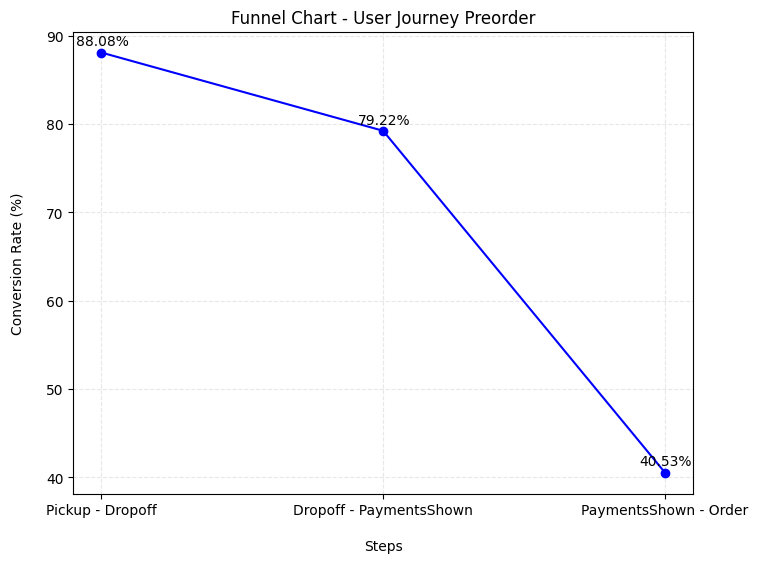

In [179]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the funnel chart
ax.plot(steps, conversion_rates, marker='o', color='b', linestyle='-')
# Add labels and title
ax.set_xlabel('\nSteps')
ax.set_ylabel('Conversion Rate (%)\n')
ax.set_title('Funnel Chart - User Journey Preorder')
# Add annotations for conversion rates
for i, rate in enumerate(conversion_rates):
    ax.annotate(f'{rate}%', (i, rate), textcoords="offset points", xytext=(0.5,5), ha='center')
plt.grid(True,alpha=0.3,linestyle='--')
plt.show()

In [180]:
# close connection:
conn.close()